# Selecting targets for visual re-inspection
Adapted from Rita Tojeiro's notebook in ritatojeiro/DESI_SV/select_targets_for_reinspection_ELG.ipynb
## QSOs - tile 68002
This notebook will merge the truth tables with Andes redrock files and select targets that need to be re-inspected, according to the following criteria:
* Redrock z changed between original and new;
* Redrock chisq or delta chisq changed by a large amount.
* New Redrock z disagrees with visual inspections;
* New Redrock Spec type differs from VI;
* The VI flag was < 2.5. N.B: I changed this to <= 2.5

In [3]:
import os, sys, glob
import numpy as np

from astropy.io import fits
from astropy.table import Table, join, vstack
from astropy.io import fits

import pandas as pd
import fnmatch

import desispec.io

sys.path.append("/global/homes/t/tamarad/SV/DESI_SV")
import VI_utils as VI

import matplotlib.pyplot as plt 

pd.set_option('display.max_rows', 50)

In [4]:
tiledir_andes='/global/cfs/cdirs/desi/spectro/redux/andes/tiles/'
tiledir = '/global/cfs/cdirs/desi/spectro/redux/daily/tiles/'
tile = '68002'
date = '20200315'
spectrograph = ['0','1', '2', '3', '4', '5', '6' ,'7', '8', '9']

In [5]:
save_filename = 'QSO_reinspection_68002.csv'

## Read in Truth Table

In [7]:
full_filename = 'truth_table_QSO_v1.2.csv'
# Put a fixed directory string here, Rita had os.environ['TT_DIR']+'/'+full_filename
truth_table = pd.read_csv('/global/cfs/cdirs/desi/sv/vi/TruthTables/'+full_filename)
#convert from pandas DataFrame to astropy Table for ease later
#truth_table = Table.from_pandas(df)

In [8]:
truth_table.keys()

Index(['TARGETID', 'Redrock z', 'best z', 'best quality', 'Redrock spectype',
       'best spectype', 'all VI issues', 'all VI comments', 'merger comment',
       'N_VI', 'DELTACHI2', 'ZWARN', 'ZERR', 'FIBER', 'FLUX_G', 'FLUX_R',
       'FLUX_Z', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z',
       'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z'],
      dtype='object')

First, add chi2 from the original reductions, as we never added that to the truth tables

In [9]:
#read in zbest info, loop over the files for all the spectrographs
tspec = Table.read(tiledir+'/'+tile + '/'+date+'/zbest-'+str(spectrograph[0])+'-'+str(tile)+'-'+date+'.fits',hdu='ZBEST')
for i in range(1,len(spectrograph)):
    tn = Table.read(tiledir+'/'+tile + '/'+date+'/zbest-'+str(spectrograph[i])+'-'+str(tile)+'-'+date+'.fits',hdu='ZBEST')
    tspec = vstack([tspec,tn])

tspec_df = tspec['TARGETID','CHI2'].to_pandas()

truth_table = truth_table.merge(tspec_df, how='left', on='TARGETID')

In [10]:
truth_table.keys()

Index(['TARGETID', 'Redrock z', 'best z', 'best quality', 'Redrock spectype',
       'best spectype', 'all VI issues', 'all VI comments', 'merger comment',
       'N_VI', 'DELTACHI2', 'ZWARN', 'ZERR', 'FIBER', 'FLUX_G', 'FLUX_R',
       'FLUX_Z', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z',
       'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'CHI2'],
      dtype='object')

Now add information from the Andes reductions: redshift, chi2, deltachi2, spectype and warning flags

In [11]:
#read in zbest info, loop over the files for all the spectrographs
tspec = Table.read(tiledir_andes+'/'+tile + '/'+date+'/zbest-'+str(spectrograph[0])+'-'+str(tile)+'-'+date+'.fits',hdu='ZBEST')
for i in range(1,len(spectrograph)):
    tn = Table.read(tiledir_andes+'/'+tile + '/'+date+'/zbest-'+str(spectrograph[i])+'-'+str(tile)+'-'+date+'.fits',hdu='ZBEST')
    tspec = vstack([tspec,tn])

tspec_df = tspec['TARGETID','Z','CHI2', 'DELTACHI2','ZWARN', 'ZERR', 'SPECTYPE' ].to_pandas()

tspec_df = tspec_df.rename(columns={"Z": "Z_andes"})
tspec_df = tspec_df.rename(columns={"CHI2": "CHI2_andes"})
tspec_df = tspec_df.rename(columns={"SPECTYPE": "SPECTYPE_andes"})

truth_table = truth_table.merge(tspec_df, how='left', on='TARGETID', suffixes=('', '_andes'))

In [12]:
truth_table.keys()

Index(['TARGETID', 'Redrock z', 'best z', 'best quality', 'Redrock spectype',
       'best spectype', 'all VI issues', 'all VI comments', 'merger comment',
       'N_VI', 'DELTACHI2', 'ZWARN', 'ZERR', 'FIBER', 'FLUX_G', 'FLUX_R',
       'FLUX_Z', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z',
       'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'CHI2',
       'Z_andes', 'CHI2_andes', 'DELTACHI2_andes', 'ZWARN_andes', 'ZERR_andes',
       'SPECTYPE_andes'],
      dtype='object')

- Redrock z changed between original and new; (done) - Redrock chisq or delta chisq changed by a large amount. (done for deltachi2) - New Redrock z disagrees with visual inspections; (done) - New Redrock Spec type differs from VI; (done) - The VI flag was < 2.5. (done)

Text(0,0.5,'DELTACHI Andes')

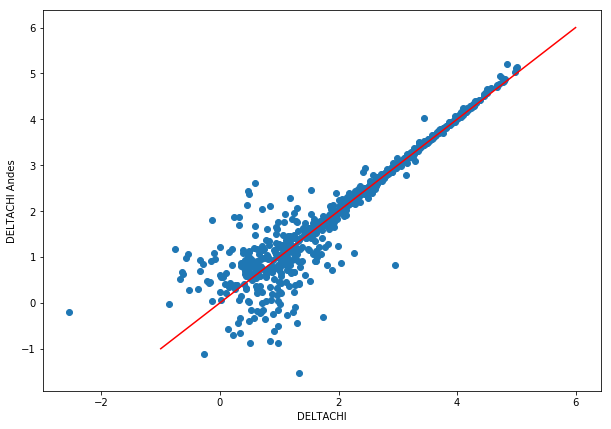

In [13]:
plt.figure(figsize=(10,7))
plt.scatter(np.log10(truth_table['DELTACHI2']), np.log10(truth_table['DELTACHI2_andes']))
plt.plot([-1,6], [-1,6], color='red')
plt.xlabel('DELTACHI')
plt.ylabel('DELTACHI Andes')

Text(0,0.5,'DELTACHI Andes')

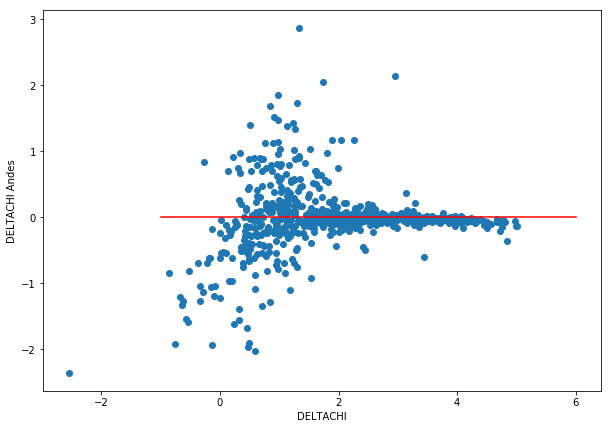

In [14]:
plt.figure(figsize=(10,7))
plt.scatter(np.log10(truth_table['DELTACHI2']), 
    (np.log10(truth_table['DELTACHI2'])-np.log10(truth_table['DELTACHI2_andes'])))
plt.plot([-1,6], [0,0], color='red')
plt.xlabel('DELTACHI')
plt.ylabel('DELTACHI Andes')

Text(0,0.5,'N')

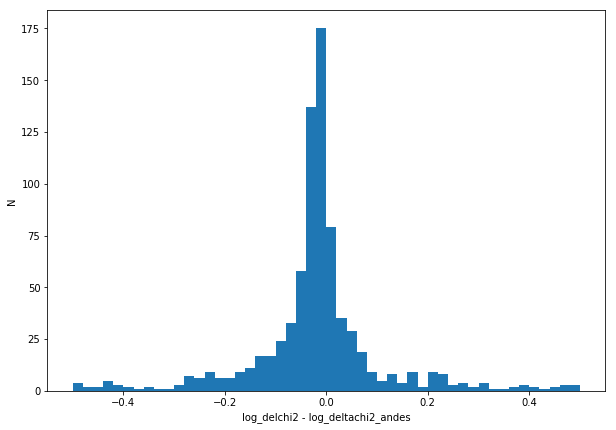

In [15]:
plt.figure(figsize=(10,7))
x=plt.hist(np.log10(truth_table['DELTACHI2'])-np.log10(truth_table['DELTACHI2_andes']), bins=50,
            range=(-0.5,0.5))
plt.xlabel('log_delchi2 - log_deltachi2_andes')
plt.ylabel('N')

I'm going to include everything for which log10_deltachi2 changed by more than 0.1 in absolute value

Text(0,0.5,'log CHI2 Andes')

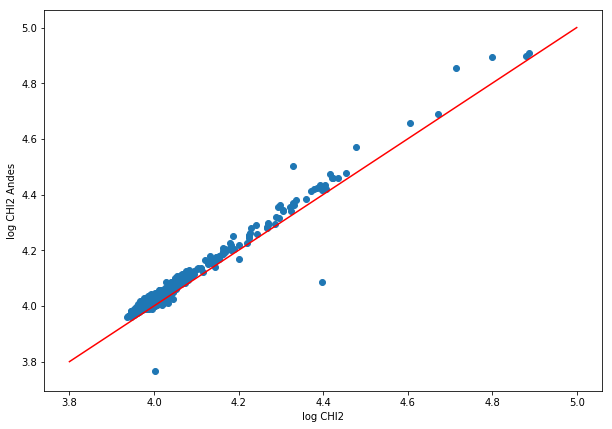

In [16]:
plt.figure(figsize=(10,7))
plt.scatter(np.log10(truth_table['CHI2']), np.log10(truth_table['CHI2_andes']))
plt.plot([3.8,5], [3.8,5], color='red')
plt.xlabel('log CHI2')
plt.ylabel('log CHI2 Andes')

Chi2 is generally higher in Andes, so I'm not going to include chi2 difference between original and Andes reductions in the criteria for re-inspection.

In [18]:
re_VI = truth_table[ \
            ((truth_table['Redrock z']-truth_table['Z_andes'])/(1+truth_table['Redrock z']) > 0.0033) | 
            ((truth_table['best z']-truth_table['Z_andes'])/(1+truth_table['best z']) > 0.0033) |
            (truth_table['best spectype'] != truth_table['SPECTYPE_andes']) |
            (truth_table['best quality'] <= 2.5) | 
            (np.abs(np.log10(truth_table['DELTACHI2'])-np.log10(truth_table['DELTACHI2_andes'])) > 0.1 )       
            ]
print(len(re_VI))

420


In [19]:
re_VI.keys()

Index(['TARGETID', 'Redrock z', 'best z', 'best quality', 'Redrock spectype',
       'best spectype', 'all VI issues', 'all VI comments', 'merger comment',
       'N_VI', 'DELTACHI2', 'ZWARN', 'ZERR', 'FIBER', 'FLUX_G', 'FLUX_R',
       'FLUX_Z', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z',
       'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'CHI2',
       'Z_andes', 'CHI2_andes', 'DELTACHI2_andes', 'ZWARN_andes', 'ZERR_andes',
       'SPECTYPE_andes'],
      dtype='object')

In [20]:
re_VI[['best z', 'Redrock z', 'Z_andes', 'best quality', 'best spectype', 'SPECTYPE_andes']]

,best z,Redrock z,Z_andes,best quality,best spectype,SPECTYPE_andes
0,1.499500,1.4995,1.499507,1.000000,GALAXY,GALAXY
1,0.410200,0.4102,0.410166,3.600000,GALAXY,GALAXY
5,0.458600,0.4586,0.458561,1.000000,GALAXY,GALAXY
6,0.935700,0.9357,0.935665,4.000000,QSO,GALAXY
7,1.500500,1.5005,1.500476,1.000000,GALAXY,GALAXY
9,0.008340,0.0080,0.007994,2.000000,STAR,GALAXY
10,0.955900,0.9559,1.005527,2.000000,GALAXY,GALAXY
12,-0.000200,-0.0002,-0.000192,4.000000,STAR,STAR
13,1.578800,1.5788,1.578776,2.500000,GALAXY,GALAXY
14,0.000000,1.6285,1.630592,3.000000,STAR,GALAXY


In [22]:
re_VI['TARGETID'].to_csv('/global/cfs/cdirs/desi/sv/vi/TruthTables/'+save_filename, index=False, header=False)

In [23]:
re_VI['TARGETID']

0      35185929937227607
1      35185929937228335
5      35185929941419181
6      35185929941419381
7      35185929941420031
             ...        
907    35185965903380947
908    35185965903382565
911    35185965903383057
912    35185965903384400
913    35185965903385357
Name: TARGETID, Length: 420, dtype: int64